In [211]:
#libraries
import numpy as np
import matplotlib as plt

In [212]:
# tef,dtt,a: array [0..1501] of longint# 
# tav,ms,Ω,djs,djs1,μ,φ,Rsat,Xsp,Xsp1,PerSat,dφs,t2,t1,Jsc,Jr1,Jr2,j12,tpl1,tpl2:array [0..1500] of real# 
# t1s,t2s,te1s,te2s,Jadd1,Jadd2,k: array [1..10,0..1501] of real#
# Pp,Ps,Rp,Ap,m,Mp,φp,dφp,dt1:longint# 
# dt,n,ts,s,t:longint# 
# Rs,xp,xp1,Xplo,Xpl,Xpln,Xpln1,Xpl1o,G,Mstar,Mplanet,Ωp,F,f1,Alb:real# 
# delt,tint,i:integer# 
# delj,dttav,jav,sigmajdtt,sigmaj,sigmadtt,Jres,Jcut,Jcuto:real#
# PpObs,t0,Korr,TTVmax,TTVmin:real# 
# PerP:real#

# Jo:array [0..1500,-70000..70000] of real#
# V1,V2,V3,V4,V5,L,S3,djp1,djp,djp0:real#
# Rz,Aps,Ass:longint# 

# xs,xs1,dJ:real# 

# te1,te2:integer# 

# nn,sumn,ntav,sumtav,Delta,DeltaPp,Deltat0:real# 

In [561]:
m=1;
ms=[None]*3
a=[None]*3
Rsat=[None]*3

G=6.67*10**(-11)#
Mstar=1.99*10**30#
Mplanet=5.99*10**24#

Mp=1#{Масса планеты в относительных единицах}
ms[0]=1/81.3#{Масса спутника-1 в массах планеты}
ms[1]=1/116.14#{Масса спутника-2 в массах планеты}
ms[2]=1/98#
Ap=149598000# {Большая полуось орбиты планеты в км} 
Pp=31556952# {Период обращения планеты вокруг звезды в сек}
Ps=245000# {Период обращения спутника вокруг планеты в сек} 
Rp=6400# {Радиус планеты в км} 
Rs=695000# {Радиус звезды в км} 

a[0]=384000#{Радиус орбиты спутника-1 в км}
a[1]=192000#{Радиус орбиты спутника-2 в км}
a[2]=699000#

Rsat[0]=2738# {Радиус спутника-1 в км} 
Rsat[1]=1225# {Радиус спутника-2 в км} 
Rsat[2]=1950#
Alb=0.3#
s=10# {Число транзитов системы спутники-планета}  
tint=2000# {Время усреднения яркости до/после затмения в сек} 
delJ=0.000007#{Погрешность измения яркости, случайная добавка принимает значения от delJ до +delJ, всегда равна нулю при delt=0} 
delt=6# {Погрешность изменения времени транзита, принимает значения от -delt до +delt, в сек} 
φp=0# what is it?
Ωp=np.sqrt(G*Mstar/1000000000/Ap/Ap/Ap)#
djp=(Rp/Rs)**2#
djp0=Rp/Rs#
PerP=2*np.pi/Ωp#
Ω=[None]*m
djs=[None]*m
μ=[None]*m
dφs=[None]*m
PerSat=[None]*m
φ=[None]*m
dφs=[None]*m
t1=[None]*s   
t2=[None]*s
Xsp=[0]*m
Xspprev=[0]*m
djs1=[None]*m
tpl1=[None]*s
tpl2=[None]*s
Ω=[None]*m
w1 = s
T=70000
t1s = [[0 for x in range(m)] for y in range(w1)] 
t2s = [[0 for x in range(m)] for y in range(w1)] 
te1s = [[0 for x in range(int(-T/10),int(T/10))] for y in range(w1)] 
te2s= [[0 for x in range(int(-T/10),int(T/10))] for y in range(w1)] 
Jo= [[0 for x in range(int(-T/10),int(T/10))] for y in range(w1)] 
Xpprev=0
Xplnprev=0

In [562]:
for i in range(m):
    Ω[i]=np.sqrt(G*Mplanet/1000000000/a[i]/a[i]/a[i])# {Доп. коэфф. необходим при переводе из км в метры}
    djs[i]=(Rsat[i]**2)/(Rs**2)# {Изменение яркости звезды во время транзита i-го спутника}
    μ[i]=(Mp/ms[i])# {Отношение масс i-го спутника к массе планеты.}
    print(Ω[i])
    print('djs= ', djs[i])#
    print('μ=', μ[i])#
#     PerSat[i]=2*np.pi/Ω[i]#
    dφs[i]=(Ω[i]*PerP/2/np.pi-int(Ω[i]*PerP/2/np.pi))# Phase shift?
    print('Ps-',i,'=',PerSat[i])#
    print('dφs-',i,'=',dφs[i])#
    
print('Pp=',PerP)#

2.6563144917024576e-06
djs=  1.5520198747476837e-05
μ= 81.3
Ps- 0 = None
dφs- 0 = 0.34070305677683876
Pp= 31555792.695338428


In [563]:
djs1[0]

In [564]:
#we have to understand this loop

# print(len(Jo))

for n in range(0,s):
    #{n-transit's number}
    for i in range(m):
        φ[i]=2*np.pi*(n*dφs[i]-int(n*dφs[i]))# current phase of each satellite?
#         print(φ[i])
    
    t=-T#  
    while t<T: #by 10 second iteration

        t=t+10#
        Jo[n][int(t/10)]=1
#         dt=dt+5
        Xplo=0#
        for i in range(m):#Contribution of every satellite to planet's position
            Xplo=Xplo-(a[i]/(μ[i]+1)*np.sin(Ω[i]*t+φ[i]))
        Xp=0#
        Xp=Xplo+Ap*np.sin(Ωp*t+φp)#{координата центра планеты в момент t}
#         Xp1=0#
#         Xp1=Xplo+Ap*np.sin(Ωp*(t+5)+φp)#{координата центра планеты в момент t+1}
#         print('Xp=',Xp)
#         print('Xp=',Xp)
        
        
        #every time check the condition:
        
        if (-Xpprev>Rs+Rp) and (-Xp<Rs+Rp):
            t1[n]=t# {Условие вступления центра планеты на диск звезды, t1[n]-время начала n-го транзита в сек}
        if (Xpprev<Rs+Rp) and (Xp>Rs+Rp):
            t2[n]=t# {Условие схода центра планеты с диска звезды, t2[n]-время окончания n-го транзита в сек}
        Xpprev=Xp
        
#{Транзиты планеты без участия спутников}
        Xpln=Ap*np.sin(Ωp*t+φp)
        Xpln1=Ap*np.sin(Ωp*(t+1)+φp)#
        
        if (-Xplnprev>Rs+Rp) and (-Xpln<Rs+Rp):
            tpl1[n]=t# {Условие вступления центра планеты на диск звезды, tpl1[n]-время начала n-го транзита в сек}
        if (Xpln<Rs+Rp) and (Xpln1>Rs+Rp):
            tpl2[n]=t# {Условие схода центра планеты с диска звезды, tpl2[n]-время окончания n-го транзита в сек} 
        Xplnprev=Xpln  
#         print('Xpl',Xp, 't=',t)

        
        for i in range(m):
            Xspprev[i]=Xsp[i]
            Xsp[i]=Xp+a[i]*(μ[i]/(μ[i]+1))*np.sin(Ω[i]*t+φ[i])# {координата центра спутника в момент t}
#             print('Xspprev=',Xspprev[i],'t=',t)
#             Xsp1[i]=Xp1+a[i]*(μ[i]/(μ[i]+1))*np.sin(Ω[i]*(t+1)+φ[i])# {координата центра спутника в момент t+1}
            if (-Xspprev[i]>Rs) and (-Xsp[i]<Rs):
                t1s[n][i]=t # {Условие вступления центра спутника на диск звезды, t1s[n]-время начала n-го транзита в сек} 
#                 print('t=',t)
            if (Xspprev[i]<Rs) and (Xsp[i]>Rs):
                t2s[n][i]=t# {Условие схода центра спутника с диска звезды, t2[n]-время окончания n-го транзита в сек}
#                 print('t=',t)
#             print('Xsp=',Xsp)
            
        for i in range(m):
            l=0
            S3=0
            v3=0 # what is it?
            v1=0
            v2=0
            if (abs(Xsp[i])<(Rs+Rsat[i])) and (abs(Xsp[i])>Rs):
                v1=1
            else:
                v1=0
                
            if  (abs(Xsp[i])>(Rs-Rsat[i])) and (abs(Xsp[i])<Rs):
                v2=1 
            else:
                v2=0
            if abs(Xsp[i])<(Rs-Rsat[i]):
                v3=1
            else:
                v3=0
            djs1[0]=0    
            if v1>0 or v2>0:
#                 Jo[n][int(t/10)]=Jo[n][int(t/10)]-djs[i]*0.5
#             if v3>0:
#                 Jo[n][int(t/10)]=Jo[n][int(t/10)]-djs[i]
# #                 print('Xsp[i]=', Xsp[i])
                l=np.sqrt(Rsat[i]**2-(abs(Xsp[i])-Rs)**2)
                S3=np.arccos(abs(-Rs+abs(Xsp[i]))/Rsat[i])*Rsat[i]**2-l*abs(-Rs+abs(Xsp[i]))
                djs1[i]=S3/(np.pi*Rs*Rs)
#             Jo[n][int(t/10)]=Jo[n][int(t/10)]-djs1[i]*v1-(djs[i]-djs1[i])*v2-djs[i]*v3#
            Jo[n][int(t/10)]=Jo[n][int(t/10)]-(1-0.65+0.65*np.sqrt(abs(1-(abs(Xsp[i]))*(abs(Xsp[i]))/Rs/Rs)))*(djs1[i]*v1+(djs[i]-djs1[i])*v2+djs[i]*v3)   
#             print(Jo[n][int(t/10)])
#             print('v3=',v3)
            
        v3=0 # what is it?
        v1=0
        v2=0
        if (abs(Xp)<(Rs+Rp)) and (abs(Xp)>Rs):
            v1=1
        else:
            v1=0 
        if  (abs(Xp)>(Rs-Rp)) and (abs(Xp)<Rs):
            v2=1 
        else:
            v2=0
        if abs(Xp)<(Rs-Rp):
            v3=1
        else:
            v3=0
        l=0
        S3=0
        if v1>0 or v2>0:
#             print('t=',t)
#             print('Xp=', Xp)
#             l=abs(abs(Xp)-Rs)
#             print('l=',l)
#             S3=1/2*(Rp**2)*np.arcsin(2*l*np.sqrt(Rp**2-l**2)/Rp**2)-l*np.sqrt(Rp**2-l**2)
            l=np.sqrt(Rp**2-(abs(Xp)-Rs)**2)
            S3=np.arccos(abs(-Rs+abs(Xp))/Rp)*Rp*Rp-l*abs(-Rs+abs(Xp))#
            djp1=S3/(np.pi*Rs*Rs)
#             Jo[n][int(t/10)]=1-djp1*v1-(djp-djp1)*v2#
#         if v3>0:
#             Jo[n][int(t/10)]=1-djp*v3
            
#         v3=1
        Jo[n][int(t/10)]=Jo[n][int(t/10)]-(1-0.65+0.65*np.sqrt(abs(1-(abs(Xp))*(abs(Xp))/Rs/Rs)))*(djp1*v1+(djp-djp1)*v2+djp*v3)
#         print('J=',Jo[n][int(t/10)])

#             djp1=(S3/(np.pi*Rs*Rs))#
            
#         Jo[n][t]=Jo[n][t]-(djp1*(V1+V5)+(djp-djp1)*(V2+V4)+djp*V3)#
#          {Jo[n,t]=Jo[n,t]-(1-0.65+0.65*np.sqrt(abs(1-(abs(Xp))*(abs(Xp))/Rs/Rs)))*(djp1*(V1)+(djp-djp1)*(V2)+djp*V3)#}

    print(t1[n])
    print(t2[n])
print(t1s)
print(t2s)

#     for i in range(m):
#         te1s[n][i]=t1[n]-t1s[n][i]#{Продолж. нахождения спутников на диске звезды до и после транзита планеты}
#         te2s[n][i]=t2s[n][i]-t2[n]#

-23550
23560
-23410
23680
-23680
23410
-23530
23580
-23420
23660
-23690
23400
-23510
23600
-23430
23650
-23700
23400
-23490
23620
[[-22570], [-34490], [-12070], [-24260], [-33570], [-11400], [-25940], [-32430], [-10960], [-27560]]
[[22580], [12990], [35210], [20910], [14100], [35670], [19270], [15410], [35890], [17710]]


In [565]:
curve=[]
index=[]
k=0
for i in range(-4000,4040):
    if Jo[2][i]!=1:
        curve.append(Jo[2][i])
        index.append(k)
        k=k+1
        print('i=',i*10,Jo[2][i])

i= -23680 0.9999999163697536
i= -23670 0.9999995873559359
i= -23660 0.9999991299668874
i= -23650 0.9999985816065926
i= -23640 0.9999979623696826
i= -23630 0.9999972858599178
i= -23620 0.9999965623718687
i= -23610 0.9999958002516007
i= -23600 0.9999950066032232
i= -23590 0.9999941877078724
i= -23580 0.9999933493014324
i= -23570 0.9999924967806557
i= -23560 0.9999916353775569
i= -23550 0.9999907703316496
i= -23540 0.999989907091282
i= -23530 0.9999890515907915
i= -23520 0.9999882106931618
i= -23510 0.9999873930045033
i= -23500 0.9999866106281855
i= -23490 0.9999858838468431
i= -23480 0.9999852593129193
i= -23470 0.9999849675062746
i= -23460 0.9999833742208337
i= -23450 0.9999820789923274
i= -23440 0.9999808379645951
i= -23430 0.9999796224081082
i= -23420 0.9999784234444469
i= -23410 0.9999772382338241
i= -23400 0.9999760665137267
i= -23390 0.9999749093758954
i= -23380 0.9999737687529046
i= -23370 0.9999726471867387
i= -23360 0.9999715477309734
i= -23350 0.999970473928932
i= -23340 0.9999

i= -18980 0.9999378081130285
i= -18970 0.999937775790912
i= -18960 0.9999377435180022
i= -18950 0.9999377112941531
i= -18940 0.9999376791192193
i= -18930 0.9999376469930563
i= -18920 0.9999376149155204
i= -18910 0.9999375828864686
i= -18900 0.9999375509057589
i= -18890 0.9999375189732497
i= -18880 0.9999374870888005
i= -18870 0.9999374552522713
i= -18860 0.9999374234635231
i= -18850 0.9999373917224175
i= -18840 0.9999373600288168
i= -18830 0.9999373283825841
i= -18820 0.9999372967835833
i= -18810 0.9999372652316789
i= -18800 0.9999372337267362
i= -18790 0.9999372022686209
i= -18780 0.9999371708572001
i= -18770 0.999937139492341
i= -18760 0.9999371081739117
i= -18750 0.9999370769017809
i= -18740 0.9999370456758182
i= -18730 0.9999370144958937
i= -18720 0.9999369833618781
i= -18710 0.9999369522736431
i= -18700 0.9999369212310607
i= -18690 0.9999368902340038
i= -18680 0.9999368592823458
i= -18670 0.9999368283759609
i= -18660 0.9999367975147239
i= -18650 0.9999367666985102
i= -18640 0.9999

i= -13970 0.9999259279460438
i= -13960 0.9999259105661173
i= -13950 0.9999258932055561
i= -13940 0.9999258758643375
i= -13930 0.9999258585424387
i= -13920 0.9999258412398372
i= -13910 0.9999258239565106
i= -13900 0.9999258066924364
i= -13890 0.9999257894475921
i= -13880 0.9999257722219557
i= -13870 0.9999257550155044
i= -13860 0.9999257378282165
i= -13850 0.9999257206600695
i= -13840 0.9999257035110415
i= -13830 0.9999256863811102
i= -13820 0.9999256692702541
i= -13810 0.9999256521784508
i= -13800 0.9999256351056786
i= -13790 0.9999256180519158
i= -13780 0.9999256010171406
i= -13770 0.9999255840013311
i= -13760 0.999925567004466
i= -13750 0.9999255500265236
i= -13740 0.9999255330674822
i= -13730 0.9999255161273206
i= -13720 0.9999254992060174
i= -13710 0.9999254823035509
i= -13700 0.9999254654199001
i= -13690 0.9999254485550437
i= -13680 0.9999254317089606
i= -13670 0.9999254148816296
i= -13660 0.9999253980730295
i= -13650 0.9999253812831393
i= -13640 0.9999253645119384
i= -13630 0.999

i= -9730 0.9999102593674043
i= -9720 0.9999102398944995
i= -9710 0.9999102204567932
i= -9700 0.9999102010541462
i= -9690 0.9999101816864204
i= -9680 0.9999101623534792
i= -9670 0.9999101430551872
i= -9660 0.9999101237914106
i= -9650 0.9999101045620166
i= -9640 0.9999100853668738
i= -9630 0.999910066205852
i= -9620 0.9999100470788225
i= -9610 0.9999100279856574
i= -9600 0.9999100089262305
i= -9590 0.9999099899004166
i= -9580 0.9999099709080915
i= -9570 0.9999099519491323
i= -9560 0.9999099330234174
i= -9550 0.999909914130826
i= -9540 0.9999098952712389
i= -9530 0.9999098764445372
i= -9520 0.9999098576506043
i= -9510 0.9999098388893234
i= -9500 0.9999098201605796
i= -9490 0.9999098014642587
i= -9480 0.9999097828002477
i= -9470 0.9999097641684345
i= -9460 0.999909745568708
i= -9450 0.999909727000958
i= -9440 0.9999097084650755
i= -9430 0.9999096899609526
i= -9420 0.9999096714884818
i= -9410 0.9999096530475569
i= -9400 0.9999096346380727
i= -9390 0.9999096162599247
i= -9380 0.9999095979130

i= -5610 0.9999043755801256
i= -5600 0.9999043653822979
i= -5590 0.9999043552010323
i= -5580 0.9999043450363145
i= -5570 0.9999043348881304
i= -5560 0.9999043247564656
i= -5550 0.9999043146413061
i= -5540 0.999904304542638
i= -5530 0.9999042944604468
i= -5520 0.999904284394719
i= -5510 0.9999042743454406
i= -5500 0.9999042643125974
i= -5490 0.9999042542961758
i= -5480 0.9999042442961619
i= -5470 0.9999042343125419
i= -5460 0.9999042243453025
i= -5450 0.9999042143944294
i= -5440 0.9999042044599097
i= -5430 0.9999041945417293
i= -5420 0.999904184639875
i= -5410 0.999904174754333
i= -5400 0.9999041648850903
i= -5390 0.9999041550321331
i= -5380 0.9999041451954485
i= -5370 0.999904135375023
i= -5360 0.9999041255708433
i= -5350 0.9999041157828962
i= -5340 0.9999041060111686
i= -5330 0.9999040962556476
i= -5320 0.9999040865163198
i= -5310 0.9999040767931724
i= -5300 0.9999040670861924
i= -5290 0.9999040573953667
i= -5280 0.9999040477206824
i= -5270 0.999904038062127
i= -5260 0.999904028419687

i= 1090 0.9999008053629045
i= 1100 0.9999008045079584
i= 1110 0.9999008036656843
i= 1120 0.9999008028360811
i= 1130 0.9999008020191475
i= 1140 0.9999008012148829
i= 1150 0.999900800423286
i= 1160 0.9999007996443559
i= 1170 0.9999007988780915
i= 1180 0.9999007981244918
i= 1190 0.9999007973835561
i= 1200 0.9999007966552831
i= 1210 0.9999007959396722
i= 1220 0.999900795236722
i= 1230 0.999900794546432
i= 1240 0.999900793868801
i= 1250 0.9999007932038281
i= 1260 0.9999007925515125
i= 1270 0.9999007919118532
i= 1280 0.9999007912848493
i= 1290 0.9999007906705002
i= 1300 0.9999007900688047
i= 1310 0.9999007894797619
i= 1320 0.9999007889033712
i= 1330 0.9999007883396316
i= 1340 0.9999007877885423
i= 1350 0.9999007872501025
i= 1360 0.9999007867243113
i= 1370 0.999900786211168
i= 1380 0.9999007857106716
i= 1390 0.9999007852228216
i= 1400 0.999900784747617
i= 1410 0.9999007842850571
i= 1420 0.9999007838351412
i= 1430 0.9999007833978685
i= 1440 0.9999007829732383
i= 1450 0.9999007825612496
i= 1460

i= 4660 0.9999013036018374
i= 4670 0.9999013072724998
i= 4680 0.9999013109560337
i= 4690 0.9999013146524415
i= 4700 0.9999013183617251
i= 4710 0.9999013220838868
i= 4720 0.9999013258189288
i= 4730 0.9999013295668532
i= 4740 0.9999013333276622
i= 4750 0.9999013371013582
i= 4760 0.9999013408879434
i= 4770 0.9999013446874199
i= 4780 0.9999013484997902
i= 4790 0.9999013523250563
i= 4800 0.9999013561632205
i= 4810 0.9999013600142853
i= 4820 0.9999013638782528
i= 4830 0.9999013677551254
i= 4840 0.9999013716449053
i= 4850 0.999901375547595
i= 4860 0.9999013794631966
i= 4870 0.9999013833917126
i= 4880 0.9999013873331454
i= 4890 0.9999013912874971
i= 4900 0.9999013952547703
i= 4910 0.9999013992349672
i= 4920 0.9999014032280904
i= 4930 0.9999014072341422
i= 4940 0.9999014112531249
i= 4950 0.9999014152850411
i= 4960 0.9999014193298932
i= 4970 0.9999014233876833
i= 4980 0.9999014274584144
i= 4990 0.9999014315420885
i= 5000 0.9999014356387083
i= 5010 0.999901439748276
i= 5020 0.9999014438707945
i= 

i= 11110 0.9999065186525365
i= 11120 0.9999065315852762
i= 11130 0.9999065445349015
i= 11140 0.9999065575014241
i= 11150 0.9999065704848568
i= 11160 0.9999065834852113
i= 11170 0.9999065965025002
i= 11180 0.9999066095367358
i= 11190 0.9999066225879303
i= 11200 0.999906635656096
i= 11210 0.9999066487412455
i= 11220 0.999906661843391
i= 11230 0.999906674962545
i= 11240 0.99990668809872
i= 11250 0.9999067012519285
i= 11260 0.9999067144221829
i= 11270 0.999906727609496
i= 11280 0.9999067408138801
i= 11290 0.999906754035348
i= 11300 0.9999067672739123
i= 11310 0.9999067805295856
i= 11320 0.9999067938023808
i= 11330 0.9999068070923104
i= 11340 0.9999068203993873
i= 11350 0.9999068337236242
i= 11360 0.9999068470650341
i= 11370 0.9999068604236295
i= 11380 0.9999068737994238
i= 11390 0.9999068871924294
i= 11400 0.9999069006026595
i= 11410 0.999906914030127
i= 11420 0.999906927474845
i= 11430 0.9999069409368264
i= 11440 0.9999069544160845
i= 11450 0.9999069679126321
i= 11460 0.9999069814264825
i

i= 15470 0.9999139810838688
i= 15480 0.9999140030887371
i= 15490 0.9999140251202135
i= 15500 0.9999140471783374
i= 15510 0.9999140692631477
i= 15520 0.999914091374684
i= 15530 0.9999141135129855
i= 15540 0.9999141356780921
i= 15550 0.9999141578700431
i= 15560 0.9999141800888786
i= 15570 0.9999142023346387
i= 15580 0.9999142246073631
i= 15590 0.9999142469070926
i= 15600 0.9999142692338672
i= 15610 0.9999142915877273
i= 15620 0.9999143139687138
i= 15630 0.9999143363768674
i= 15640 0.999914358812229
i= 15650 0.9999143812748397
i= 15660 0.9999144037647406
i= 15670 0.9999144262819729
i= 15680 0.9999144488265782
i= 15690 0.9999144713985981
i= 15700 0.9999144939980743
i= 15710 0.9999145166250487
i= 15720 0.9999145392795632
i= 15730 0.9999145619616602
i= 15740 0.9999145846713815
i= 15750 0.9999146074087699
i= 15760 0.999914630173868
i= 15770 0.9999146529667183
i= 15780 0.9999146757873638
i= 15790 0.9999146986358474
i= 15800 0.9999147215122124
i= 15810 0.999914744416502
i= 15820 0.9999147673487

i= 19580 0.9999259552415104
i= 19590 0.9999259942089639
i= 19600 0.9999260332453109
i= 19610 0.9999260723508088
i= 19620 0.9999261115257163
i= 19630 0.9999261507702937
i= 19640 0.9999261900848037
i= 19650 0.9999262294695102
i= 19660 0.9999262689246794
i= 19670 0.9999263084505792
i= 19680 0.9999263480474792
i= 19690 0.9999263877156512
i= 19700 0.999926427455369
i= 19710 0.9999264672669078
i= 19720 0.9999265071505452
i= 19730 0.9999265471065608
i= 19740 0.9999265871352357
i= 19750 0.9999266272368539
i= 19760 0.9999266674117006
i= 19770 0.9999267076600633
i= 19780 0.9999267479822317
i= 19790 0.9999267883784977
i= 19800 0.9999268288491551
i= 19810 0.9999268693944998
i= 19820 0.9999269100148301
i= 19830 0.9999269507104463
i= 19840 0.9999269914816511
i= 19850 0.9999270323287491
i= 19860 0.9999270732520474
i= 19870 0.9999271142518555
i= 19880 0.999927155328485
i= 19890 0.9999271964822497
i= 19900 0.999927237713466
i= 19910 0.9999272790224529
i= 19920 0.9999273204095311
i= 19930 0.999927361875

i= 24200 0.9999860381548196
i= 24210 0.9999860408538954
i= 24220 0.999986043555969
i= 24230 0.999986046261043
i= 24240 0.9999860489691204
i= 24250 0.9999860516802038
i= 24260 0.9999860543942963
i= 24270 0.9999860571114009
i= 24280 0.9999860598315202
i= 24290 0.9999860625546573
i= 24300 0.999986065280815
i= 24310 0.9999860680099962
i= 24320 0.9999860707422039
i= 24330 0.9999860734774411
i= 24340 0.9999860762157106
i= 24350 0.9999860789570152
i= 24360 0.9999860817013582
i= 24370 0.9999860844487423
i= 24380 0.9999860871991705
i= 24390 0.9999860899526457
i= 24400 0.9999860927091712
i= 24410 0.9999860954687496
i= 24420 0.9999860982313841
i= 24430 0.9999861009970775
i= 24440 0.9999861037658331
i= 24450 0.9999861065376537
i= 24460 0.9999861093125424
i= 24470 0.9999861120905023
i= 24480 0.9999861148715361
i= 24490 0.9999861176556473
i= 24500 0.9999861204428385
i= 24510 0.9999861232331132
i= 24520 0.9999861260264741
i= 24530 0.9999861288229245
i= 24540 0.9999861316224673
i= 24550 0.999986134425

i= 28110 0.9999873589227746
i= 28120 0.9999873631083336
i= 28130 0.9999873672988651
i= 28140 0.9999873714943776
i= 28150 0.9999873756948798
i= 28160 0.9999873799003807
i= 28170 0.9999873841108888
i= 28180 0.9999873883264132
i= 28190 0.9999873925469626
i= 28200 0.9999873967725458
i= 28210 0.9999874010031718
i= 28220 0.9999874052388495
i= 28230 0.999987409479588
i= 28240 0.9999874137253961
i= 28250 0.9999874179762831
i= 28260 0.9999874222322578
i= 28270 0.9999874264933294
i= 28280 0.9999874307595071
i= 28290 0.9999874350308
i= 28300 0.9999874393072175
i= 28310 0.9999874435887685
i= 28320 0.9999874478754623
i= 28330 0.9999874521673086
i= 28340 0.9999874564643163
i= 28350 0.9999874607664949
i= 28360 0.9999874650738539
i= 28370 0.9999874693864027
i= 28380 0.9999874737041508
i= 28390 0.9999874780271075
i= 28400 0.9999874823552826
i= 28410 0.9999874866886854
i= 28420 0.9999874910273259
i= 28430 0.9999874953712133
i= 28440 0.9999874997203577
i= 28450 0.9999875040747684
i= 28460 0.9999875084344

i= 34070 0.9999914815772692
i= 34080 0.9999914949134264
i= 34090 0.9999915083136974
i= 34100 0.9999915217789282
i= 34110 0.9999915353099844
i= 34120 0.999991548907751
i= 34130 0.9999915625731334
i= 34140 0.9999915763070581
i= 34150 0.9999915901104738
i= 34160 0.9999916039843512
i= 34170 0.9999916179296844
i= 34180 0.9999916319474917
i= 34190 0.9999916460388164
i= 34200 0.999991660204727
i= 34210 0.9999916744463192
i= 34220 0.999991688764716
i= 34230 0.9999917031610691
i= 34240 0.9999917176365597
i= 34250 0.9999917321923997
i= 34260 0.9999917468298329
i= 34270 0.999991761550136
i= 34280 0.99999177635462
i= 34290 0.9999917912446314
i= 34300 0.9999918062215536
i= 34310 0.9999918212868082
i= 34320 0.999991836441857
i= 34330 0.9999918516882029
i= 34340 0.999991867027392
i= 34350 0.9999918824610153
i= 34360 0.9999918979907104
i= 34370 0.9999919136181636
i= 34380 0.9999919293451119
i= 34390 0.9999919451733452
i= 34400 0.9999919611047084
i= 34410 0.9999919771411041
i= 34420 0.9999919932844947


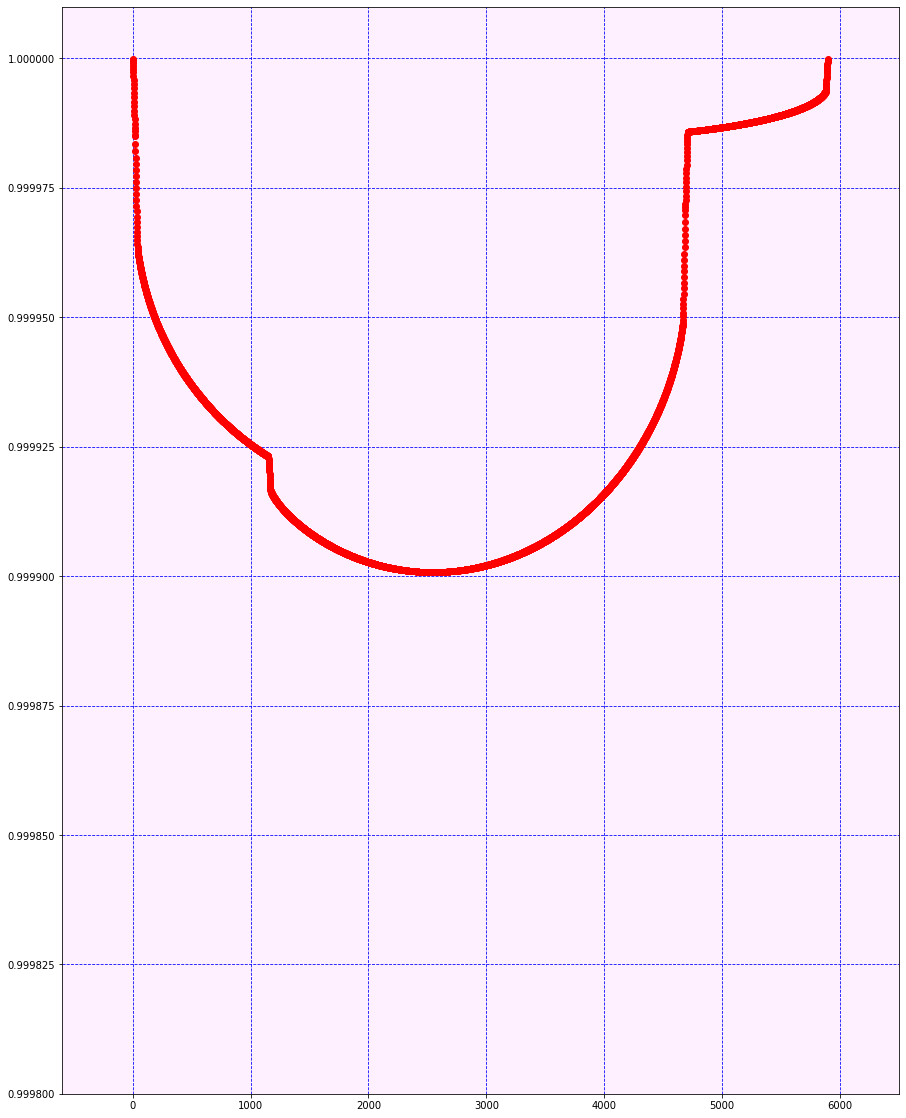

In [566]:
import matplotlib.pyplot as plt 

from os import path
import matplotlib.backends.backend_pdf
import matplotlib.dates as mdates

  
f=plt.figure(figsize=[15,20])
plt.gca().set_xlim([-600,6500])
plt.gca().set_ylim([0.9998,1.00001])
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10000))

ax = plt.gca()
ax.set_facecolor((1.0, 0.94, 1))
plt.plot(index,curve,'ro')

plt.grid(True,color='blue',linestyle="--")
plt.show()

In [571]:
tav

[5.0, 135.0, -135.0, 25.0, 120.0, -145.0, 45.0, 110.0, -150.0, 65.0]

In [567]:
Jr1=[0]*s
Jr2=[0]*s
J12=[0]*s
tav=[0]*s
nn=0
sumn=0
ntav=0
sumtav=0

for n in range(s):
    for t in range(np.round(t1[n]-tint),np.round(t1[n])):
                   Jr1[n]=Jr1[n]+Jo[n][int(t/10)]
              
    for t in range(np.round(t2[n]),np.round(t2[n]+tint)):
                   Jr2[n]=Jr2[n]+Jo[n][int(t/10)]#

                   
for n in range(s):
    print(n,'Jr1= ',Jr1[n])#
    print(n,'Jr2= ',Jr2[n])# 
    Jr1[n]=Jr1[n]/tint#
    Jr2[n]=Jr2[n]/tint#
    J12[n]=Jr2[n]/Jr1[n]# {отношение j2[n] и j1[n]}
#     {j12[n]=j12[n]+2*delj*(np.random(delt+1)-(delt+1)/2)/(delt+1)#}
    print('J12[',n,']=',J12[n],'#')#


# for n in range(s):
#     t1[n]=t1[n]+2*Random(delt+1)-(delt+1)#{Эта строчка и две следующие - случайные погрешности
#     t2[n]=t2[n]+2*Random(delt+1)-(delt+1)# }


for n in range(s):
    tav[n]=np.round((t1[n]+t2[n])/2)# {tav[n]-время середины n-того
    nn=nn+n*n# {отсюда и до конца абзаца составление эфемериды планеты методом наименьших квадратов
    sumn=sumn+n# 
    ntav=ntav+n*tav[n]# 
    sumtav=sumtav+tav[n]# 


Delta=nn*(s+1)-sumn*sumn# 
DeltaPp=ntav*(s+1)-sumtav*sumn# 
Deltat0=nn*sumtav-sumn*ntav# 
PpObs=DeltaPp/Delta# 
t0=Deltat0/Delta

                   
             
print('Pp=', PpObs,' t0=',t0)# {ppObs-наблюдаемый период обращения планеты вокруг звезды, на основе известных времен транзитов в сек} 
# {t0- постоянная, входящая в эферемениду, измеряется в сек} 




# {for n=0 to s do tpl1[n]=PpObs*(n-arcnp.sin(Rs/Ap)/2/pi)#
# for n=0 to s do tpl2[n]=PpObs*(n+arcnp.sin(Rs/Ap)/2/pi)#}
# {for n=0 to s do dtt[n]=np.round(tav[n])-tef[n]# {dtt[n] - вариация времени середины n-того транзита планеты в сек
# for n=0 to s do tef[n]=np.round(n*PpObs+t0)# tef[n] - время середины n-того транзита планеты согласно эфемериде в сек} 









# for n=0 to s do dtt[n]=np.round((t1[n]-tpl1[n]+t2[n]-tpl2[n])/2)# {dtt[n] - вариация времени середины n-того транзита планеты в сек} 
# print('dtt[n]=','  ',dtt[n])#

# {for n=0 to s do print('TDV[',n,']=',-(tpl2[n]-tpl1[n])+(t2[n]-t1[n]),'#')#}

# for n=0 to s do print('[',(t1[n]-tpl1[n]+t2[n]-tpl2[n])/2,',',(1-1/J12[n])*1000000:3:3,']',',')# 

# {for n=0 to s do print('[',(t1[n]-tpl1[n]+t2[n]-tpl2[n])/2,',', -(tpl2[n]-tpl1[n])+(t2[n]-t1[n]),']',',')#}

# {for n=0 to s do print('TTV[',n,']=',trunc((t1[n]-tpl1[n]+t2[n]-tpl2[n])/2),'#')#}
# jav=0# for n=0 to s do jav=jav+j12[n]/(s+1)# print('jav=',jav:8:8)#
# dttav=0# for n=0 to s do dttav=dttav+dtt[n]/(s+1)# print('dttav=',dttav:8:4)#
# Sigmaj=0# for n=0 to s do Sigmaj=Sigmaj+j12[n]*j12[n]-jav*jav# Sigmaj=np.sqrt(Sigmaj)#
# Sigmadtt=0# for n=0 to s do Sigmadtt=Sigmadtt+dtt[n]*dtt[n]-dttav*dttav# Sigmadtt=np.sqrt(Sigmadtt)#
# Sigmajdtt=0# for n=0 to s do Sigmajdtt=Sigmajdtt+(j12[n]-jav)*(dtt[n]-dttav)# 
# print(Sigmaj,' ',Sigmadtt,' ',Sigmajdtt)# 
# Korr=Sigmajdtt/Sigmaj/Sigmadtt# 
# print('Коэффициент корреляции, Korr=', Korr:4:3)# 
# end.



0 Jr1=  1999.999998810001
0 Jr2=  2000.0
J12[ 0 ]= 1.0000000005949996 #
1 Jr1=  1999.9726286171401
1 Jr2=  2000.0
J12[ 1 ]= 1.0000136858787305 #
2 Jr1=  1999.9999992473272
2 Jr2=  1999.9721983707684
J12[ 2 ]= 0.9999860995617154 #
3 Jr1=  1999.9946951588156
3 Jr2=  2000.0
J12[ 3 ]= 1.0000026524276275 #
4 Jr1=  1999.9732432519277
4 Jr2=  2000.0
J12[ 4 ]= 1.0000133785530194 #
5 Jr1=  1999.9999994620623
5 Jr2=  1999.9719156058773
J12[ 5 ]= 0.9999859580719037 #
6 Jr1=  1999.982228260246
6 Jr2=  2000.0
J12[ 6 ]= 1.0000088859488363 #
7 Jr1=  1999.974075170165
7 Jr2=  2000.0
J12[ 7 ]= 1.000012962582944 #
8 Jr1=  1999.9999999904967
8 Jr2=  1999.9717731117182
J12[ 8 ]= 0.9999858865606106 #
9 Jr1=  1999.9790197214807
9 Jr2=  2000.0
J12[ 9 ]= 1.0000104902493039 #
Pp= -1.8513513513513513  t0= 14.391891891891891


In [224]:
4*np.pi/6-np.sqrt(3)/4

1.661382400500976

In [ ]:
Ω=1
print(Ω)